In [1]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]
!pip3 install ipdb

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

     |████████████████████████████████| 448 kB 29.5 MB/s 
     |████████████████████████████████| 793 kB 12.9 MB/s 
     |████████████████████████████████| 381 kB 43.5 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=90bcf0c9643e68ab51f1c7c2a9f16b4a4aefd88500583b3878487736f222f3ff
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires

In [2]:
import gym
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from gym import wrappers
import time
from IPython.display import clear_output

In [3]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob
import base64, io
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from gym.wrappers import Monitor

#Q Network Class

In [4]:
"""
Q-network class
"""
class QNetwork(nn.Module):
  def __init__(self, num_states, num_actions, hidden_layers, seed=0):
    super(QNetwork, self).__init__()
    self.seed = torch.manual_seed(seed)
    self.fc1 = nn.Linear(num_states, hidden_layers[0])
    self.fc2 = nn.Linear(hidden_layers[0], hidden_layers[1])
    self.fc3 = nn.Linear(hidden_layers[1], num_actions)

  def forward(self, X):
    X = F.relu((self.fc1(X)))
    X = F.relu((self.fc2(X)))
    return self.fc3(X)

# Memory Classes

In [5]:
#define data structure for experience 
Experience = namedtuple('Experience',
                        ('state', 'action', 'next_state', 'reward', 'done'))


"""
Replay Memory to store experiences 
"""
class ReplayMemory:
  def __init__(self, mem_capacity, rand_seed):
    #self.num_actions = num_actions
    self.memory = deque(maxlen = mem_capacity)
    self.seed = random.seed(rand_seed)

  """
  Magic method to return size of memory
  """
  def __len__(self):
    return len(self.memory)

  """
  Add experience to memory
  """
  def add_experience(self, state, action, next_state, reward, done):
    self.memory.append(Experience(state, action, next_state, reward, done))

  """
  Get n experiences from memory
  """
  def sample_exp(self, n):

    #get n exp
    experiences = random.sample(self.memory, k=n)

    states = [] 
    actions = []
    rewards = [] 
    next_states = [] 
    dones = []  

    #get states, actions..
    for e in experiences:
      if e is not None:
        state, action, next_state, reward, done = e
        states.append(state)
        actions.append(action)
        next_states.append(next_state)
        rewards.append(reward)
        dones.append(done)

    #convert to tensors 
    states = torch.from_numpy(np.vstack(states)).to(torch.float).to(device)
    actions = torch.from_numpy(np.vstack(actions)).to(torch.long).to(device)
    next_states = torch.from_numpy(np.vstack(next_states)).to(torch.float).to(device)
    rewards = torch.from_numpy(np.vstack(rewards)).to(torch.float).to(device)
    dones = torch.from_numpy(np.vstack(dones).astype(np.uint8)).to(torch.float).to(device)

    #return as tuple 
    return (states, actions, next_states, rewards, dones)


In [6]:

"""
Priority Experience Replay Memory
"""

class PERMemory:
  def __init__(self, mem_capacity, rand_seed, alpha):
    self.alpha = alpha 
    self.mem_capacity = mem_capacity
    self.memory = np.empty(self.mem_capacity, dtype=[("priority", np.float32), ("experience", Experience)])
    self.seed = np.random.RandomState(rand_seed)
    self.mem_length = 0


  """
  returns current size of memory
  """
  def __len__(self):
    return self.mem_length

  """
  adds experience to memory and sets priority
  """
  def add_experience(self, state, action, next_state, reward, done):
    experience = Experience(state, action, next_state, reward, done)

    ##if first entry
    if self.mem_length == 0:
      priority = 1
    else:
      priority = self.memory['priority'].max() 

    ##if memory is full 
    if self.mem_length == self.mem_capacity:
      ##check if priority of new exp is more than the exp with the least priority is memory 
      ##and add to memeory 
      all_priorities = self.memory['priority']
      if priority > all_priorities.min():
        self.memory[all_priorities.argmin()] = (priority, experience)
    else:
      self.memory[self.mem_length] = (priority, experience)
      self.mem_length += 1

  """
  Get n experiences from memory
  returns: experiences from memory & their indexes + weights    
  """
  def sample_exp(self, n, beta):
    #get priorities of all experiences 
    priorities = self.memory[:self.mem_length]['priority']
    sampling_probs = priorities**self.alpha / np.sum(priorities**self.alpha)
    #sample n experiences 
    idxs = self.seed.choice(np.arange(self.mem_length), size = n, replace = True, p = sampling_probs)
    exp = self.memory['experience'][idxs]
    weights = (self.mem_length * sampling_probs[idxs])**-beta 
    weights_norm = weights / weights.max() 

    return idxs, exp, weights_norm

  """
  Helper Function to convert array of experiences to tensors
  """
  def convert_exp_to_tensor(self, experiences):
    states = [] 
    actions = []
    rewards = [] 
    next_states = [] 
    dones = []  

    #get states, actions..
    for e in experiences:
      if e is not None:
        state, action, next_state, reward, done = e
        states.append(state)
        actions.append(action)
        next_states.append(next_state)
        rewards.append(reward)
        dones.append(done)

    #convert to tensors 
    states = torch.from_numpy(np.vstack(states)).to(torch.float).to(device)
    actions = torch.from_numpy(np.vstack(actions)).to(torch.long).to(device)
    next_states = torch.from_numpy(np.vstack(next_states)).to(torch.float).to(device)
    rewards = torch.from_numpy(np.vstack(rewards)).to(torch.float).to(device)
    dones = torch.from_numpy(np.vstack(dones).astype(np.uint8)).to(torch.float).to(device)

    return (states, actions, next_states, rewards, dones)




# Agent Class

In [7]:
class Agent():

  def __init__(self, num_states, num_actions, seed, learning_rate, memory_capacity, batch_size, update_frequency, gamma, tau, alpha, beta, ddqn = True, per = True):
    self.num_states = num_states
    self.num_actions = num_actions
    self.seed = seed #random.seed(seed)
    self.update_frequency = update_frequency 
    self.batch_size = batch_size
    self.gamma = gamma 
    self.tau = tau 
    self.ddqn = ddqn
    self.time_step = 0 
    self.per = per 
    self.beta = beta
    self.num_episodes = 0 


    #Q-network 
    # local = policy, target = target 
    self.policy_net = QNetwork(num_states, num_actions, [64, 64], self.seed).to(device)
    self.target_net = QNetwork(num_states, num_actions,[64,64],  self.seed).to(device)
    #initialize target with policy net params 
    self.sync_networks()

    self.optimizer = optim.Adam(self.policy_net.parameters(), lr = learning_rate)

    #memory
    if per:
      self.memory = PERMemory(memory_capacity, self.seed, alpha)
    else:
      self.memory = ReplayMemory(memory_capacity, self.seed)


  """
  sync both networks
  """
  def sync_networks(self):
    _ = self.target_net.load_state_dict(self.policy_net.state_dict())

  """
  Agent executes action to build knowledge base
  Every n steps, learns from experience 
  """
  def execute_action(self, state, action, reward, next_state, done):
    #add experience
    self.memory.add_experience(state, action, reward, next_state, done)

    
    #back prop every n steps 
    if done:
      self.num_episodes += 1
    else:
      self.time_step += 1 


    if self.time_step % self.update_frequency == 0:
      #check if there are enough experiences
      if len(self.memory) > self.batch_size:
        if self.per:
          #sample from per 
          self.beta = 1 - np.exp(-1e-2 * self.num_episodes)
          idxs, exps, weights = self.memory.sample_exp(self.batch_size, self.beta)
          #learn from experience 
          self.per_learn(idxs, exps, weights, self.gamma)
        else:
          #sample from replay mempry
          exp = self.memory.sample_exp(self.batch_size)
          #learn from experience
          self.ddqn_learn(exp, self.gamma)


  """
  Select an actions based on actions available for a given state
  """
  def select_action(self, state, eps = 0 ):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    #turn off grad for forward pass 
    self.policy_net.eval()
    with torch.no_grad():
        actions = self.policy_net(state)
    self.policy_net.train()
    
    # Epsilon-greedy action selection
    if random.random() > eps:
        return np.argmax(actions.cpu().data.numpy())
    else:
        return random.choice(np.arange(self.num_actions))
  """
  Learns from prior experiences 
  for per + dqn (or) per + ddqn 
  """
  def per_learn(self, indexes, experiences, weights, gamma):
    states, actions, rewards, next_states, dones = self.memory.convert_exp_to_tensor(experiences)

    

    #get error in q calculation
    if self.ddqn:
       _, q_values = self.policy_net(next_states).max(dim =1 , keepdim = True) #gets actions 
    else:
      #add code for dqn 
      _, q_values = self.target_net(next_states).max(dim =1 , keepdim = True) #gets actions 

    q_values_next = self.target_net(next_states).gather(dim = 1, index = q_values)
    target_q_values = rewards + gamma * q_values_next * (1 - dones)
    policy_q_values = self.policy_net(states).gather(1, actions)
    q_error = target_q_values - policy_q_values 

    #fix dimenions for remainign calcs 
    actions = (actions.long().unsqueeze(dim=1))
    rewards = rewards.unsqueeze(dim=1)
    dones = dones.unsqueeze(dim=1)

    #update priorities 
    priorities = (q_error.abs().cpu().detach().numpy().flatten())
    self.memory.memory["priority"][indexes] = priorities + 1e-6 #ensure val is positive 

    #calculate loss 
    weights = (torch.Tensor(weights).view((-1, 1))).to(device)
    loss = torch.mean((q_error * weights)**2)
    
    #back-prop
    self.optimizer.zero_grad()
    loss.backward() 
    self.optimizer.step()

    #sync networks 
    self.sync_networks()


  """
  Learns from prior experiences
  only for ddqn + dqn 
  """
  def ddqn_learn(self, experiences, gamma):
    states, actions, rewards, next_states, dones = experiences 

    # Target Q-value calculation 
    # Q-value of next state 
    if self.ddqn:
      _, q_values = self.policy_net(next_states).max(dim =1 , keepdim = True) #gets actions 
      
    else:
      _, q_values = self.target_net(next_states).max(dim =1 , keepdim = True) #gets actions 

    q_values_next = self.target_net(next_states).gather(dim = 1, index = q_values)
    target_q_values = rewards + gamma * q_values_next * (1 - dones)

    policy_q_values = self.policy_net(states).gather(1, actions)


    ### Loss calculation 
    loss = F.mse_loss(policy_q_values, target_q_values)

    
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    #update target net based on policy net 
    for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
       target_param.data.copy_(self.tau*policy_param.data + (1.0-self.tau)*target_param.data)

    

#Training Function

In [14]:
def train_ddqn(env, agent, fname, num_episodes = 2000, max_steps = 1000, eps_start = 1.0, eps_end = 0.01, eps_decay = 0.995):
  scores = [] 
  scores_window = deque(maxlen = 100)
  eps = eps_start 

  for i in range(1, num_episodes+1):
    state = env.reset() 
    current_score = 0 
    for step in range(max_steps):
      #select action 
      action = agent.select_action(state, eps)
      #take action in environment
      next_state, reward, done, _ = env.step(action)
      #store experience in memory & learn 
      agent.execute_action(state, action, reward, next_state, done)
      
      #update state & rewards 
      state = next_state 
      current_score += reward

      # game over 
      if done:
        break 

    #save episode scores   
    scores_window.append(current_score)       
    scores.append(current_score)                    
    
    #decay epsilon 
    eps = max(eps_end, eps_decay*eps) 

    #Score printing formatting  
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)), end="")
    if i % 100 == 0:
          print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)))

    #break condition to stop training 
    if np.mean(scores_window)>=200.0:
          print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i-100, np.mean(scores_window)))
          torch.save(agent.policy_net.state_dict(), fname)
          break
          
  return scores





#Code for visualization

In [15]:
def play_game(env, agent, render, checkpoint_fname = None):
    done = False
    state = env.reset()
    reward_total = 0

    if checkpoint_fname:
      policy_net = QNetwork(num_states, num_actions, [64, 64]).to(device)
      policy_net.load_state_dict(torch.load(checkpoint_fname))
      policy_net.eval()
    else:
      policy_net = agent.policy_net


    

    while not done:
        state_t = torch.from_numpy(state).float().unsqueeze(0).to(device)
        action = policy_net(state_t).max(1)[1].view(1, 1)
        
        state, reward, done, _ = env.step(action.item())
        reward_total += reward
        
        if render: env.render()
        
    
    if render:
        env.close()
        show_video()
    
    print(f'reward = {reward_total}')


def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# Environment Setup

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

game = 'LunarLander-v2'
env = gym.make(game)

print("game: ", game)
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n

print("States size:", num_states, "Actions size: ",  num_actions)

device:  cuda:0
game:  LunarLander-v2
States size: 8 Actions size:  4


# Train agent on PER + DDQN

In [17]:
#set up parameters for agent
seed = 0
learning_rate = 5e-4
memory_capacity = 100000
batch_size = 64
update_every = 4
gamma = 0.99 
tau = 0.001
ddqn = True #using DQN now
per = True
alpha = 0.5 #0 - uniform sampling 
beta = 1 #fix this to decay - doesnt matter, dont need to pass in 

#training params 
num_episodes = 2000 ##changes this 
max_steps = 1000
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995

checkpoint_fname = 'ddqn_per.pth'

agent = Agent(num_states, num_actions, seed, learning_rate, memory_capacity, batch_size, update_every, gamma, tau, alpha, beta, ddqn, per )
scores = train_ddqn(env, agent, checkpoint_fname, num_episodes, max_steps , eps_start, eps_end , eps_decay)




Episode 100	Average Score: -173.78
Episode 200	Average Score: -94.70
Episode 300	Average Score: -33.38
Episode 400	Average Score: -52.96
Episode 500	Average Score: 16.30
Episode 600	Average Score: 170.72
Episode 700	Average Score: 146.94
Episode 800	Average Score: 194.76
Episode 823	Average Score: 201.01
Environment solved in 723 episodes!	Average Score: 201.01


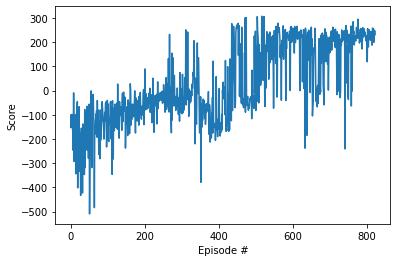

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [21]:
display = Display(visible=0, size=(1400, 900))
display.start()

env = wrap_env(gym.make('LunarLander-v2'))
play_game(env, agent, True, checkpoint_fname)

reward = 268.8302348515681


# Train agent on PER + DDQ

In [22]:
#set up parameters for agent
seed = 0
learning_rate = 5e-4
memory_capacity = 100000
batch_size = 64
update_every = 4
gamma = 0.99 
tau = 0.001
ddqn = False
per = True
alpha = 0.5 #0 - uniform sampling 
beta = 1 #fix this to decay - doesnt matter, dont need to pass in 

#training params 
num_episodes = 2000
max_steps = 1000
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995

checkpoint_fname = 'dqn_per.pth'

time_start = time.time()
agent = Agent(num_states, num_actions, seed, learning_rate, memory_capacity, batch_size, update_every, gamma, tau, alpha, beta, ddqn, per )
scores = train_ddqn(env, agent, checkpoint_fname, num_episodes, max_steps , eps_start, eps_end , eps_decay)
print("Time elapsed: ", time.time()-time_start, " s")


Episode 100	Average Score: -127.49
Episode 200	Average Score: -56.13
Episode 300	Average Score: 62.51
Episode 400	Average Score: 160.88
Episode 500	Average Score: 195.07
Episode 600	Average Score: 181.61
Episode 640	Average Score: 200.07
Environment solved in 540 episodes!	Average Score: 200.07
Time elapsed:  1032.5227925777435  s


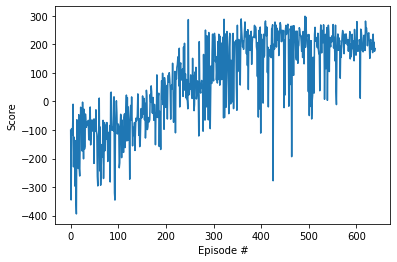

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [25]:
display = Display(visible=0, size=(1400, 900))
display.start()

env = wrap_env(gym.make('LunarLander-v2'))
play_game(env, agent, True, checkpoint_fname)

reward = 218.37132595229633


#Train Agent on DDQN

In [26]:
#set up parameters for agent
seed = 0
learning_rate = 5e-4
memory_capacity = 100000
batch_size = 64
update_every = 4
gamma = 0.99 
tau = 0.001
ddqn = False #using DQN now
per = False
alpha = 0.5 #0 - uniform sampling 
beta = 1 #fix this to decay - doesnt matter, dont need to pass in 

#training params 
num_episodes = 2000
max_steps = 1000
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995

checkpoint_fname = 'ddqn.pth'

time_start = time.time()
agent = Agent(num_states, num_actions, seed, learning_rate, memory_capacity, batch_size, update_every, gamma, tau, alpha, beta, ddqn, per )
scores = train_ddqn(env, agent, checkpoint_fname, num_episodes, max_steps , eps_start, eps_end , eps_decay)
print("Time elapsed: ", time.time()-time_start, " s")


Episode 100	Average Score: -183.44
Episode 200	Average Score: -117.52
Episode 300	Average Score: -44.08
Episode 400	Average Score: 80.86
Episode 500	Average Score: 163.01
Episode 577	Average Score: 200.31
Environment solved in 477 episodes!	Average Score: 200.31
Time elapsed:  657.1591284275055  s


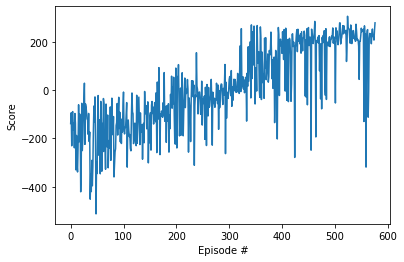

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [28]:

display = Display(visible=0, size=(1400, 900))
display.start()
env = wrap_env(gym.make('LunarLander-v2'))
play_game(env, agent, True, checkpoint_fname)

reward = 198.71160877767198


# Train Agent on DQN

In [29]:
#set up parameters for agent
seed = 0
learning_rate = 5e-4
memory_capacity = 100000
batch_size = 64
update_every = 4
gamma = 0.99 
tau = 0.001
ddqn = False #using DQN now
per = False

#training params 
num_episodes = 2000
max_steps = 1000
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995

checkpoint_fname = 'dqn.pth'

time_start = time.time()
agent = Agent(num_states, num_actions, seed, learning_rate, memory_capacity, batch_size, update_every, gamma, tau, alpha, beta, ddqn, per )
scores = train_ddqn(env, agent, checkpoint_fname, num_episodes, max_steps , eps_start, eps_end , eps_decay)
print("Time elapsed: ", time.time()-time_start, " s")



Episode 100	Average Score: -181.32
Episode 200	Average Score: -108.73
Episode 300	Average Score: -63.20
Episode 400	Average Score: 46.10
Episode 500	Average Score: 122.16
Episode 600	Average Score: 134.28
Episode 688	Average Score: 200.22
Environment solved in 588 episodes!	Average Score: 200.22
Time elapsed:  866.4243557453156  s


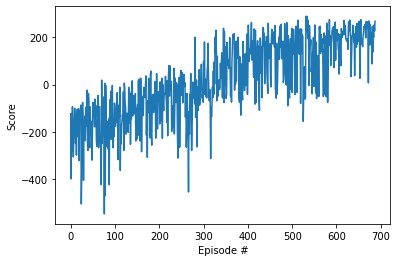

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [33]:
display = Display(visible=0, size=(1400, 900))
display.start()
env = wrap_env(gym.make('LunarLander-v2'))
play_game(env, agent, True, checkpoint_fname)

reward = 241.41245042049425
